In [1]:
import numpy as np
import pandas as pd

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics


from sklearn.cluster import AffinityPropagation

from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import LabelPropagation

C:\Users\HP\anaconda3\envs\Pytorchgpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\HP\anaconda3\envs\Pytorchgpu\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\HP\anaconda3\envs\Pytorchgpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import re
from tqdm import tqdm
from string import punctuation
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
nltk.download('wordnet')
from gensim.models.fasttext import FastText
lemma = WordNetLemmatizer()
stop_words=stopwords.words('english')

# stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
# from fasttext import load_model
from nltk.tokenize import RegexpTokenizer 
from sklearn.preprocessing import MultiLabelBinarizer

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [3]:
from gensim.models import Word2Vec
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,SpatialDropout1D,LSTM,Bidirectional
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import utils as np_utils
from tensorflow.python.client import device_lib 

print(device_lib.list_local_devices())
from IPython.display import display, HTML

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 534887004902164637
]


In [4]:
train_df=pd.read_csv('./project/training_data.csv')
test_df=pd.read_csv('./project/testing_data.csv')

In [5]:
# label encoding with maintaining dimension
label_df=train_df[train_df['category']!='None']
label_df['category_label']=label_df['category'].factorize()[0]
unlabeled_df=train_df[train_df['category']=='None']

<ipython-input-5-264749fe8534>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['category_label']=label_df['category'].factorize()[0]


In [119]:
print(label_df['category_label'].nunique())
print(label_df['category'].nunique())

6
6


In [120]:
category_id_df = label_df[['category', 'category_label']].drop_duplicates()
category_id_df

y=label_df['category_label']
y = np_utils.to_categorical(y, num_classes=6)


## Text Preprocessing 

In [121]:
def text_normalize(text):
    
    # remove special characters\whitespaces
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text), re.I | re.A)
    # convert to lower 
    clean_text=text.lower()
    
    # Remove extra white space from text
    clean_text = re.sub(r'\s+', ' ', clean_text, flags=re.I)
         
    # Remove all the special characters from text
    clean_text = re.sub(r'\W', ' ', str(clean_text))
    
    clean_text = re.sub(r'\d', ' ', str(clean_text))
    
    # Word tokenization       
    tokens = clean_text.split()
    
    
    stop_word = set(stopwords.words('english')) | set(punctuation)| set(ENGLISH_STOP_WORDS)
    
    # re-create text from filtered lemmatize tokens
    cleaned_text = ' '.join(lemma.lemmatize(token) for token in tokens if token not in stop_word)
    
    return cleaned_text


## Training Fasttext Model 



In [8]:
title_list=train_df['title'].tolist()
clean_corpus = [text_normalize(sentence) for sentence in tqdm(title_list) if sentence.strip() !='']
word_tokenizer = nltk.WordPunctTokenizer()

word_tokens = [word_tokenizer.tokenize(sent) for sent in tqdm(clean_corpus)]
# word_tokens[:5]

100%|████████████████████████████████████████████████████████████████████████| 20188/20188 [00:00<00:00, 260900.11it/s]


[['amigo'],
 ['home',
  'essential',
  'blue',
  'floral',
  'glass',
  'vintage',
  'style',
  'water',
  'goblet',
  'set'],
 ['cooper',
  'wiring',
  'quiet',
  'toggle',
  'switch',
  'single',
  'pole',
  'lighted',
  'v',
  'ivory',
  'ul',
  'boxed'],
 ['baseboarders', 'reg', 'wall', 'bracket'],
 ['great',
  'wave',
  'kanagawa',
  'custom',
  'rectangle',
  'mouse',
  'pad',
  'oblong',
  'gaming',
  'mousepad',
  'mm',
  'mm',
  'mm',
  'quot',
  'quot']]

In [9]:
# Defining values for parameters
embedding_size = 300
window_size = 3
min_word = 3
down_sampling = 1e-2
 

fast_Text_model = FastText(word_tokens,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      workers = 4,
                      sg=1,epochs=10)


In [10]:
# # Save fastText gensim model
# fast_Text_model.save("./models/fasttext_train")

# # Load saved gensim fastText model
fast_Text_model =FastText.load("models/fasttext_train")

## Creating Embeddings


In [11]:
def get_embedding(word):
    try:
        embedding=fast_Text_model.wv[word]
    except:
        pass
#         embedding=np.zeros((300,)) 
        
    return embedding

In [12]:
embeddings_index = {}
vocab_dict=fast_Text_model.wv.key_to_index

for i in vocab_dict.keys():
    embed=get_embedding(i)
    embed=np.asarray(embed,dtype='float32')
    embeddings_index[i]=embed

In [13]:
embeddings_index

{'quot': array([ 0.03980461, -0.03657162,  0.16508462, -0.2595823 ,  0.06023468,
        -0.09726179,  0.21657342,  0.26926658, -0.30527246,  0.21003129,
         0.2673393 ,  0.2080562 ,  0.13670515,  0.02828879, -0.44922802,
         0.14420734, -0.04748113, -0.04517848, -0.59561944,  0.09906743,
        -0.14981459,  0.27767256, -0.06149365,  0.5032001 , -0.15033738,
        -0.16006054,  0.2556725 , -0.08676719,  0.05934735, -0.02416241,
        -0.10151846, -0.10416264, -0.1277822 , -0.16691788,  0.06845195,
        -0.21432467,  0.4422597 ,  0.23901914, -0.30368134, -0.06822725,
         0.19154401,  0.23265667,  0.1552335 ,  0.07004729, -0.31502557,
         0.17292123, -0.14959198, -0.20009866, -0.06096896,  0.02578875,
         0.01043902,  0.29922494,  0.0314635 ,  0.16565062, -0.02594056,
        -0.17291236, -0.11105149,  0.18161525,  0.65348047, -0.21778797,
        -0.32213253,  0.03848451,  0.04363749, -0.30143592,  0.14844073,
         0.12477124,  0.43188074,  0.135085

## Data Preparation

In [122]:
tokenizer = RegexpTokenizer(r'\w+')

raw_docs_train=label_df['title'].tolist()
raw_docs_test=unlabeled_df['title'].tolist()

category_list=category_id_df['category'].tolist()
num_classes = len(category_list)


######################################################################
print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [lemma.lemmatize(word) for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

print("pre-processing test data...")
processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))


pre-processing train data...


100%|█████████████████████████████████████████████████████████████████████████| 10065/10065 [00:00<00:00, 15197.91it/s]


pre-processing test data...


100%|█████████████████████████████████████████████████████████████████████████| 10123/10123 [00:00<00:00, 36436.37it/s]


In [15]:
MAX_NB_WORDS = 20000

##  Creating sequence

In [16]:
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)

tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)

word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)


label_df['doc_len'] = label_df['title'].apply(lambda words: len(words.split(" ")))
# max_seq_len = np.round(label_df['doc_len'].mean() + label_df['doc_len'].std()).astype(int)
max_seq_len=300

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

tokenizing input data...
dictionary size:  33095


<ipython-input-16-2c00f9173d51>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['doc_len'] = label_df['title'].apply(lambda words: len(words.split(" ")))


In [17]:
word_seq_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### Fitting Embedding matrix to our data

In [18]:
# vars#model parameters
embed_dim = 300 
nb_words = min(MAX_NB_WORDS, len(word_index))


In [19]:
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
#         print(embedding_vector)
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print('number of word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) != 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

preparing embedding matrix...
number of null word embeddings: 12838
number of word embeddings: 7162
sample words not found:  ['doweling' 'csm' 'c3' 'cerveza' 'mvp' '17w' 'navigation' 'hod012541' 'a7'
 'licensing']


In [20]:
print('training data shape: ',np.shape(word_seq_train))
print('training label shape: ',y.shape)
print('embedding matrix shape: ',np.shape(embedding_matrix))

training data shape:  (10065, 300)
training label shape:  (10065, 11)
embedding matrix shape:  (20000, 300)


## Training Various Architechtures

--CNN \
--BiLSTM



In [21]:
#training params
batch_size = 128
num_epochs = 10

max_features = 1000
maxlen = 250
filters = 250
kernel_size = 3
hidden_dims = 250

import tensorflow as tf

In [199]:

# CNN with max pooling imeplementation 
print('Build model...')
model = Sequential()
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(6))
model.add(Activation('softmax'))
model.summary()



#define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
# callbacks_list = [early_stopping]
# import tensorflow as tf

try:
    with tf.device('/device:GPU:0'):
        X_train = tf.convert_to_tensor(word_seq_train, dtype=tf.int32)
        Y_train = tf.convert_to_tensor(y, dtype=tf.float32)
        model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
except RuntimeError as e:
      print(e)
        

model.fit(X_train,y,epochs=num_epochs,validation_split=0.20)

Build model...
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_41 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_22 (Glo (None, 250)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_42 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_38 (Activation)   (None, 25

KeyboardInterrupt: 

##    Trying Hyperparameters

In [126]:

# CNN with max pooling imeplementation 
print('Build model...')
model = Sequential()
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(6))
model.add(Activation('sigmoid'))
model.summary()



try:
    with tf.device('/device:GPU:0'):
        X_train = tf.convert_to_tensor(word_seq_train, dtype=tf.int32)
        Y_train = tf.convert_to_tensor(y, dtype=tf.float32)
        model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
except RuntimeError as e:
      print(e)

history=model.fit(X_train,y,epochs=num_epochs,validation_split=0.30)

Build model...
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_21 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 250)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_22 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_20 (Activation)   (None, 25

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


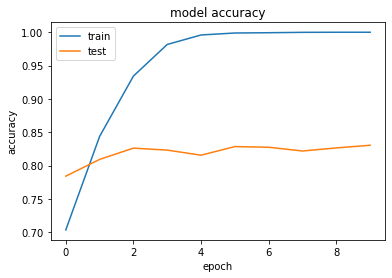

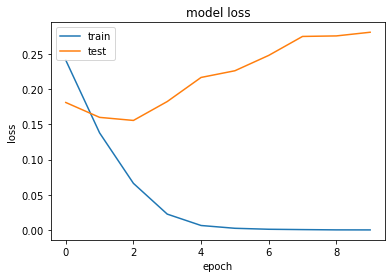

In [128]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Another CNN Architecture

## Adding Layer Normalization 

In [130]:
num_filters = 64 
weight_decay = 1e-4
print(max_seq_len)
max_seq_len=300
num_epochs=5
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
model.add(layers.LayerNormalization())
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(6, activation='softmax'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.summary()
# model training
try:
    with tf.device('/device:GPU:0'):
        X_train = tf.convert_to_tensor(word_seq_train, dtype=tf.int32)
        Y_train = tf.convert_to_tensor(y, dtype=tf.float32)
        model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
except RuntimeError as e:
      print(e)

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True, verbose=2)

300
training CNN ...
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
layer_normalization_2 (Layer (None, 300, 300)          600       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 300, 64)           134464    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 150, 64)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 150, 64)           28736     
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 64)                0         
_________________________________________________________________
dropout_24 (Dropout)         (No

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


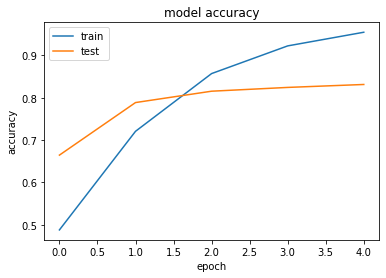

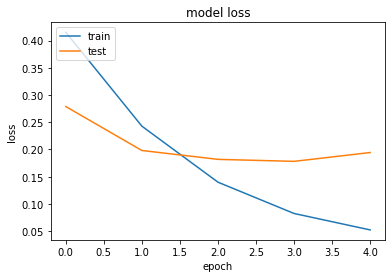

In [131]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### BiLSTM  model

In [ ]:
epochs=10
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
model.add(layers.LayerNormalization())
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))

model.add(Dense(11, activation='softmax'))
try:
    with tf.device('/device:GPU:0'):
        X_train = tf.convert_to_tensor(word_seq_train, dtype=tf.int32)
        Y_train = tf.convert_to_tensor(y, dtype=tf.float32)
        model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
except RuntimeError as e:
      print(e)


print(model.summary())


In [ ]:

# define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
# callbacks_list = [early_stopping]
# history = model.fit(word_seq_train, y, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)],verbose=1)

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [132]:

from sklearn.model_selection import KFold
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import RegexpTokenizer 
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
stop_words=stopwords.words('english')
from tqdm import tqdm
lemma = WordNetLemmatizer()
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder

In [159]:
# max_seq_len=300

# print('training word seq :\n', word_seq_train[1],'\n')

le=LabelEncoder()
y_encoded=le.fit_transform(label_df['category'].values)
print('labels encoded shape',y_encoded.shape)

x_train,x_test,y_train,y_test=train_test_split(word_seq_train,y)

# X_pad = pad_sequences(x_train, maxlen=max_seq_len)
# X_test_pad = pad_sequences(x_test, maxlen=max_seq_len)

# print(' label train seq padded',X_pad[1])
print('seq shape',word_seq_train.shape)
print('unlabed(None)seq shape',word_seq_test.shape)
print('labels shape -- y',y.shape)

print('training seq shape  --x_train:',x_train.shape)
print('testing seq shape -- x_test:',x_test.shape)

print('category train label shape -- y_train:',y_train.shape)
print('category test label shape -- y_test',y_test.shape)

# print('padded train seq shape  -- X_pad: ',X_pad.shape)
# print('padded unlabed test seq shape  -- X_pad: ',X_pad.shape)




labels encoded shape (10065,)
seq shape (10065, 300)
unlabed(None)seq shape (10123, 300)
labels shape -- y (10065, 6)
training seq shape  --x_train: (7548, 300)
testing seq shape -- x_test: (2517, 300)
category train label shape -- y_train: (7548, 6)
category test label shape -- y_test (2517, 6)


In [109]:
def get_new_train_data(predictions, fold_n):
    X_new = list()
    y_new = list()
    
    for i, prediction in enumerate(predictions):
#         print(prediction)
        if (prediction.all() > 0.95 or prediction.all()<0.05):
            X_new.append(X_fold[fold_n][i])
            y_new.append(np.argmax(prediction))
        
    return np.array(X_new), np.array(y_new)

In [66]:
def join_shuffle(X_train, y_train, X_new, y_new):
    X_train = np.vstack((X_train, X_new))
    y_train = np.append(y_train, y_new)
    
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    return X_train[indices], y_train[indices]

In [168]:
kf = KFold(n_splits=3, shuffle=True)

X_fold = list()
y_fold = list()

for _, fold in kf.split(x_train):
    
    X_fold.append(x_train[fold])
    y_fold.append(y_train[fold])
    
X_fold = np.array(X_fold)
y_fold = np.array(y_fold)

# The 0th fold will be our known labeled, the rest folds are assumed to be unlabeled
X_train1 = X_fold[0]
y_train1 = y_fold[0]
print('folded train data X_train1: ', X_train1.shape)
print('folded train labels y_train1: ', y_train1.shape)


folded train data X_train1:  (2516, 300)
folded train labels y_train1:  (2516, 6)


In [173]:

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout

def create_model():
    # CNN with max pooling imeplementation 
    print('Build model...')
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
    model.add(Dropout(0.2))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    model.summary()
    
    try:
        with tf.device('/device:GPU:0'):
            model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    except RuntimeError as e:
          print(e)
    return model

In [174]:
import numpy
model = create_model()

Build model...
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_31 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 250)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_32 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_28 (Activation)   (None, 25

In [175]:
print(X_train.shape)
print(X_train1.shape)
print(y_train1.shape)


(10065, 300)
(2516, 300)
(2516, 6)


In [178]:
model= create_model()
model.fit(X_train1[:-1000], y_train1[:-1000], epochs=2,validation_data=(X_train1[-1000:], y_train1[-1000:]), shuffle=True, verbose=1)


Build model...
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_37 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 250)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_38 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_34 (Activation)   (None, 25

In [181]:
predictions = model.predict(X_fold[1])
print('predictions',predictions)


predictions [[0.1109463  0.01790392 0.0338425  0.9154686  0.01196933 0.07980454]
 [0.2717387  0.11760893 0.5262377  0.07663602 0.10908759 0.12881908]
 [0.3061146  0.2445929  0.14477462 0.018087   0.0451124  0.14926445]
 ...
 [0.422254   0.00147626 0.00626653 0.93861306 0.0013957  0.01611158]
 [0.8785591  0.05040297 0.05004674 0.01379034 0.00912774 0.01902142]
 [0.68838453 0.06194302 0.33174658 0.03614905 0.04129767 0.06832865]]
new train data after predictions (2516, 300) labels (2516,)
shuffle train data X_train2 (5032, 300)
shuffle test data y_train2 (5032,)


In [193]:

X_new, y_new = get_new_train_data(predictions, 1)

X_train2, y_train2 = join_shuffle(X_train1, y_train1, X_new, y_new)

print('new train data after predictions {} and labels {}'.format(X_new.shape,y_new.shape))
print('shuffle train data X_train2',X_train2.shape)
print('shuffle test data y_train2',y_train2.shape)
y_train2=np_utils.to_categorical(y_train2, num_classes=6)


print('shuffle test data y_train2 categorizing',y_train2.shape)

new train data after predictions (2516, 300) and labels (2516,)
shuffle train data X_train2 (5032, 300)
shuffle test data y_train2 (5032,)
shuffle test data y_train2 categorizing (5032, 6)


In [189]:
category_list
print(y_new[10])

1


In [192]:
print([category_list[i] for i in y_new[:1]])
print(y_new[:2])
print(y_train2[:2])

['Grocery & Gourmet Food']
[3 2]
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [194]:

model = create_model()
model.fit(X_train2[:-1000], y_train2[:-1000], epochs=3, 
          validation_data=(X_train2[-1000:], y_train2[-1000:]))

# Predict samples in fold 2
predictions = model.predict(X_fold[2])


Build model...
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_39 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 250)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_40 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_36 (Activation)   (None, 25

In [195]:
# Filter out samples in fold 2
X_new, y_new = get_new_train_data(predictions, 2)
print('label_new_updated shape y_new',y_new.shape)


label_new_updated shape y_new (2516,)


In [198]:
# Concatenate new data to X_train and y_train
X_train3, y_train3 = join_shuffle(X_train2, y_train2, X_new, y_new)
y_train3=np_utils.to_categorical(y_train3, num_classes=6)


model.fit(X_train3, y_train3, 
          validation_data=(x_test, y_test))

Epoch 1/2
236/236 [==============================] - 41s 172ms/step - loss: 0.1573 - accuracy: 0.8308 - val_loss: 0.7613 - val_accuracy: 0.4938
Epoch 2/2
236/236 [==============================] - 40s 172ms/step - loss: 0.1374 - accuracy: 0.8356 - val_loss: 0.7766 - val_accuracy: 0.4942


In [203]:
num_epochs=10
# CNN with max pooling imeplementation 
print('Build model...')
model = Sequential()
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(nb_words,300,input_length=max_seq_len, trainable=True))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(6,))
model.add(Activation('softmax'))
model.summary()



#define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
# callbacks_list = [early_stopping]
# import tensorflow as tf

try:
    with tf.device('/device:GPU:0'):
        X_train = tf.convert_to_tensor(word_seq_train, dtype=tf.int32)
        Y_train = tf.convert_to_tensor(y, dtype=tf.float32)
        model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
except RuntimeError as e:
      print(e)
        

model.fit(X_train,y,epochs=num_epochs,validation_split=0.20)

Build model...
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_45 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_24 (Glo (None, 250)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_46 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_42 (Activation)   (None, 25